# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [79]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [80]:
today = datetime.datetime.now() - datetime.timedelta(0)
# tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 8, 10, 46, 3, 113330)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [81]:
with open('../data/keys/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="ML_Project_Electricity", api_key_value=os.environ["HOPSWORKS_API_KEY"])
fs = project.get_feature_store() 

2025-01-08 10:46:05,266 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 10:46:05,297 INFO: Initializing external client
2025-01-08 10:46:05,298 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 10:46:06,532 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207495


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [82]:
feature_view_se3 = fs.get_feature_view(
    name='se3_price_fv',
    version=1,
)

feature_view_se4 = fs.get_feature_view(
    name='se4_price_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [83]:
mr = project.get_model_registry()

retrieved_model_se3 = mr.get_model(
    name="se3_price_xgboost_model_new",
    version=1,
)

retrieved_model_se4 = mr.get_model(
    name="se4_price_xgboost_model_new",
    version=1,
)



# Download the saved model artifacts to a local directory
saved_model_dir_se3 = retrieved_model_se3.download()
saved_model_dir_se4 = retrieved_model_se4.download()

In [10]:
print(saved_model_dir_se3)

/var/folders/sw/7rz0xqrj5w1f6jz2qqrxk8800000gn/T/2b955d3d-c2a7-46c7-8063-5395b3297b64/se3_price_xgboost_model_new/1


In [84]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_se3 = XGBRegressor()

retrieved_xgboost_model_se3.load_model(saved_model_dir_se3 + "/model_se3.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_se3

retrieved_xgboost_model_se4 = XGBRegressor()

retrieved_xgboost_model_se4.load_model(saved_model_dir_se4 + "/model_se4.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_se4

XGBRegressor(base_score='4.8940155E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'int', 'float', 'int',
                            'int', 'int', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [85]:
sthlm_weather_fg = fs.get_feature_group(
    name='stockholm_weather',
    version=1,
)

malmo_weather_fg = fs.get_feature_group(
    name='malmo_weather',
    version=1,
)

sthlm_weather_data = sthlm_weather_fg.filter(sthlm_weather_fg.date >= today).read()
malmo_weather_data = malmo_weather_fg.filter(malmo_weather_fg.date >= today).read()

# Ensure the 'date' column is in datetime format
sthlm_weather_data['date'] = pd.to_datetime(sthlm_weather_data['date'])
malmo_weather_data['date'] = pd.to_datetime(malmo_weather_data['date'])

# Sort the weather data by the 'date' column
sthlm_weather_data.sort_values(by='date', inplace=True)
malmo_weather_data.sort_values(by='date', inplace=True)

sthlm_weather_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


,date,time,temperature,precipitation,cloud_cover,wind_speed_10m,weekday,month,hour,sunshine_duration
0,2025-01-09 00:00:00+00:00,2025-01-09 07:00:00+00:00,-1.90,0.0,45,8.699793,3,1,7,0.000000
31,2025-01-09 00:00:00+00:00,2025-01-09 10:00:00+00:00,-2.00,0.0,65,8.089993,3,1,10,0.000000
23,2025-01-09 00:00:00+00:00,2025-01-09 02:00:00+00:00,-1.70,0.0,63,7.636753,3,1,2,0.000000
34,2025-01-09 00:00:00+00:00,2025-01-09 11:00:00+00:00,-1.85,0.0,74,7.771331,3,1,11,0.000000
21,2025-01-09 00:00:00+00:00,2025-01-09 05:00:00+00:00,-1.50,0.0,48,8.217153,3,1,5,0.000000
...,...,...,...,...,...,...,...,...,...,...
49,2025-01-11 00:00:00+00:00,2025-01-11 16:00:00+00:00,-2.40,0.0,75,19.881649,5,1,16,16120.420898
48,2025-01-11 00:00:00+00:00,2025-01-11 17:00:00+00:00,-2.60,0.0,47,19.826164,5,1,17,16120.420898
70,2025-01-11 00:00:00+00:00,2025-01-11 03:00:00+00:00,-1.55,0.1,100,26.339111,5,1,3,16120.420898
58,2025-01-11 00:00:00+00:00,2025-01-11 14:00:00+00:00,-2.20,0.1,100,20.570463,5,1,14,16120.420898


In [86]:
# skip the feature view and simply get the last available rolling mean from the price feature group
se3_price_fg = fs.get_feature_group(
    name='se3_electricity_prices',
    version=1,
)

se4_price_fg = fs.get_feature_group(
    name='se4_electricity_prices',
    version=1,
)

se3_price_data = se3_price_fg.read()
se4_price_data = se4_price_fg.read()

# Ensure the 'time' column is in datetime format
se3_price_data['time'] = pd.to_datetime(se3_price_data['time'])
se4_price_data['time'] = pd.to_datetime(se4_price_data['time'])

# Sort the price data by the 'time' column
se3_price_data.sort_values(by='time', inplace=True)
se4_price_data.sort_values(by='time', inplace=True)

se3_price_data.tail()

# get the last available rolling mean from the price feature group
se3_last_rolling_mean = se3_price_data['spot_price_rolling'].iloc[-1]
se4_last_rolling_mean = se4_price_data['spot_price_rolling'].iloc[-1]


# se3_last_rolling_mean

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


In [39]:
se3_price_data.tail()

,time,pricearea,spotpriceeur,spot_price_rolling
8793,2025-01-07 18:00:00+00:00,SE3,20.55,15.465476
8787,2025-01-07 19:00:00+00:00,SE3,14.78,15.414940
8783,2025-01-07 20:00:00+00:00,SE3,6.15,15.274345
8788,2025-01-07 21:00:00+00:00,SE3,4.92,15.145774
8792,2025-01-07 22:00:00+00:00,SE3,4.03,15.025417


In [87]:
# Add the last available rolling mean to the weather data

sthlm_weather_data['spot_price_rolling'] = se3_last_rolling_mean
malmo_weather_data['spot_price_rolling'] = se4_last_rolling_mean

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [88]:
# Use the models to predict electricity prices using the weather data
sthlm_features = sthlm_weather_data.drop(columns=['date', 'time'])
malmo_features = malmo_weather_data.drop(columns=['date', 'time'])

# Reoder columns
# Assuming you have the feature names expected by the model
expected_feature_names = ['spot_price_rolling', 'temperature', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'weekday', 'month', 'hour', 'sunshine_duration']
# Reorder the columns in the DataFrame to match the expected order
sthlm_features = sthlm_weather_data[expected_feature_names]
malmo_features = malmo_weather_data[expected_feature_names]

# Print the column names
print(sthlm_features.columns)
print(malmo_features.columns)

sthlm_predictions = retrieved_xgboost_model_se3.predict(sthlm_features)
malmo_predictions = retrieved_xgboost_model_se4.predict(malmo_features)

# Create a DataFrame to store the predictions
predictions_df_se3 = pd.DataFrame({
    'time': sthlm_weather_data['time'],
    'predicted_price': sthlm_predictions,
})

predictions_df_se4 = pd.DataFrame({
    'time': malmo_weather_data['time'],
    'predicted_price': malmo_predictions,
})


Index(['spot_price_rolling', 'temperature', 'precipitation', 'cloud_cover',
       'wind_speed_10m', 'weekday', 'month', 'hour', 'sunshine_duration'],
      dtype='object')
Index(['spot_price_rolling', 'temperature', 'precipitation', 'cloud_cover',
       'wind_speed_10m', 'weekday', 'month', 'hour', 'sunshine_duration'],
      dtype='object')


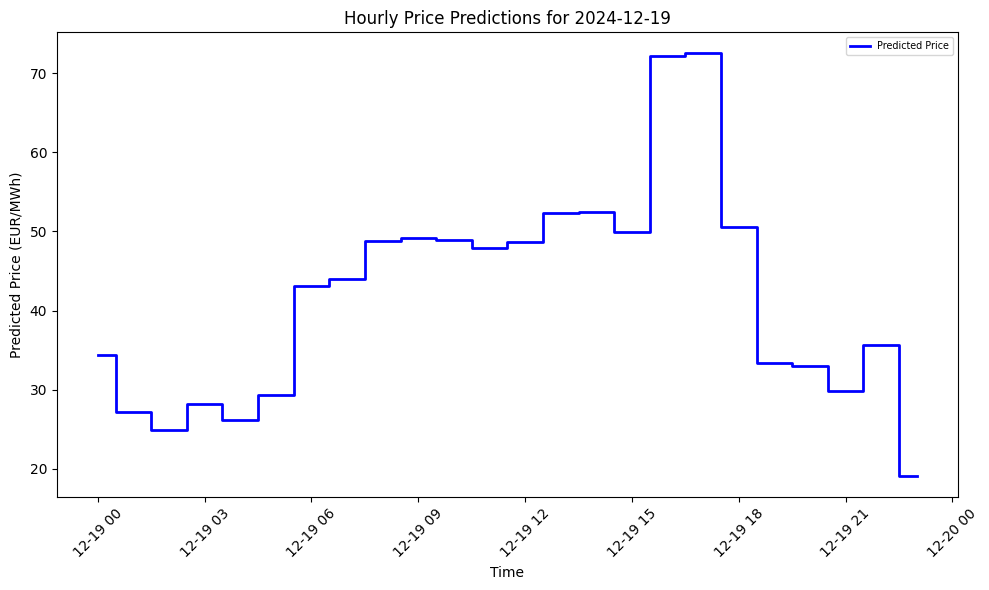

In [ ]:
# Display the predictions
def plot_hourly_price_predictions(df: pd.DataFrame, date: str, file_path: str):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Filter the DataFrame for the specified date
    df['time'] = pd.to_datetime(df['time'])
    df_filtered = df[df['time'].dt.date == pd.to_datetime(date).date()]

    # Sort the DataFrame by time to ensure the steps are in the correct order
    df_filtered = df_filtered.sort_values(by='time')

    # Plot the predicted prices using a step plot
    ax.step(df_filtered['time'], df_filtered['predicted_price'], where='mid', label='Predicted Price', color='blue', linewidth=2)

    # Set the labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Predicted Price (EUR/MWh)')
    ax.set_title(f"Hourly Price Predictions for {date}")

    # Add a legend
    ax.legend(loc='upper right', fontsize='x-small')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt
# file_path = "../plots/hourly_price_predictions.png"
# date_to_plot = '2024-12-19'
# plt = plot_hourly_price_predictions(predictions_df_se3, date_to_plot, file_path)
# plt.show()

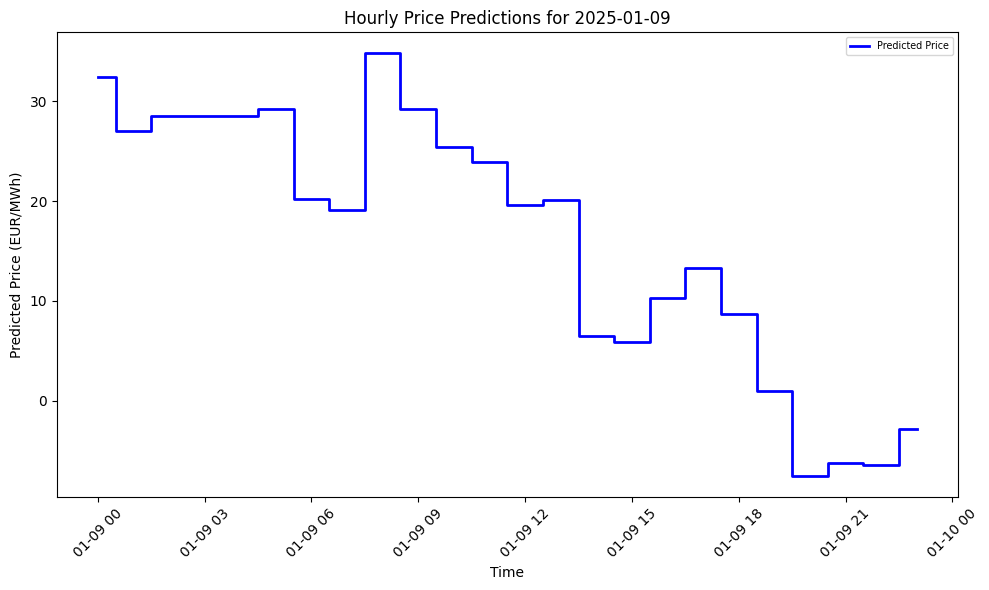

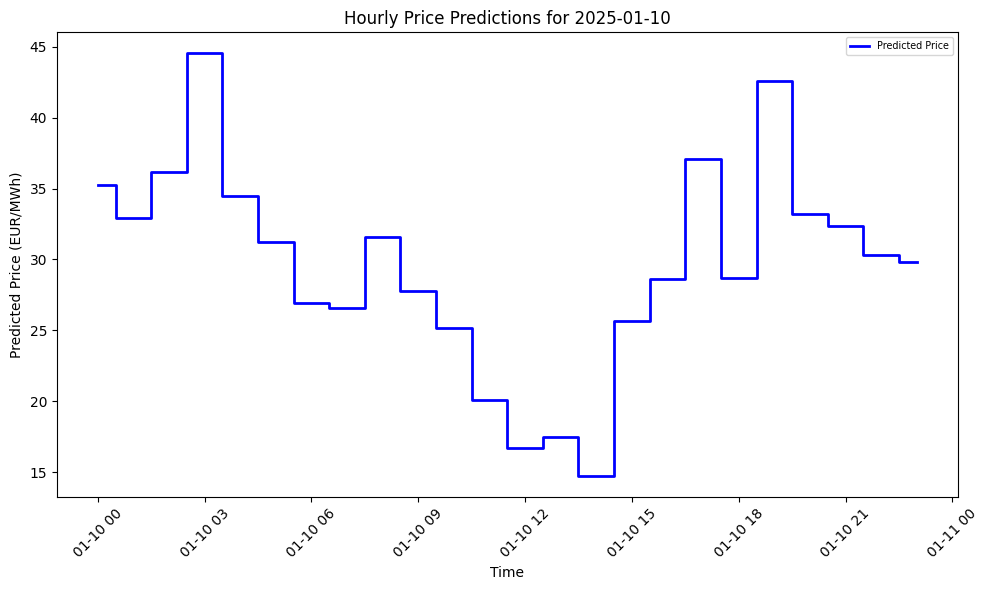

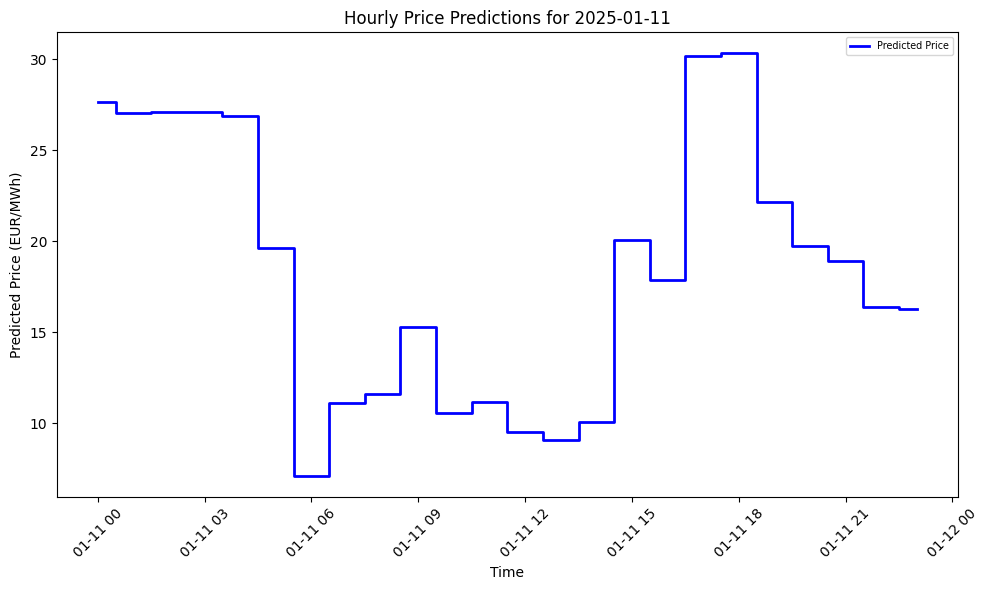

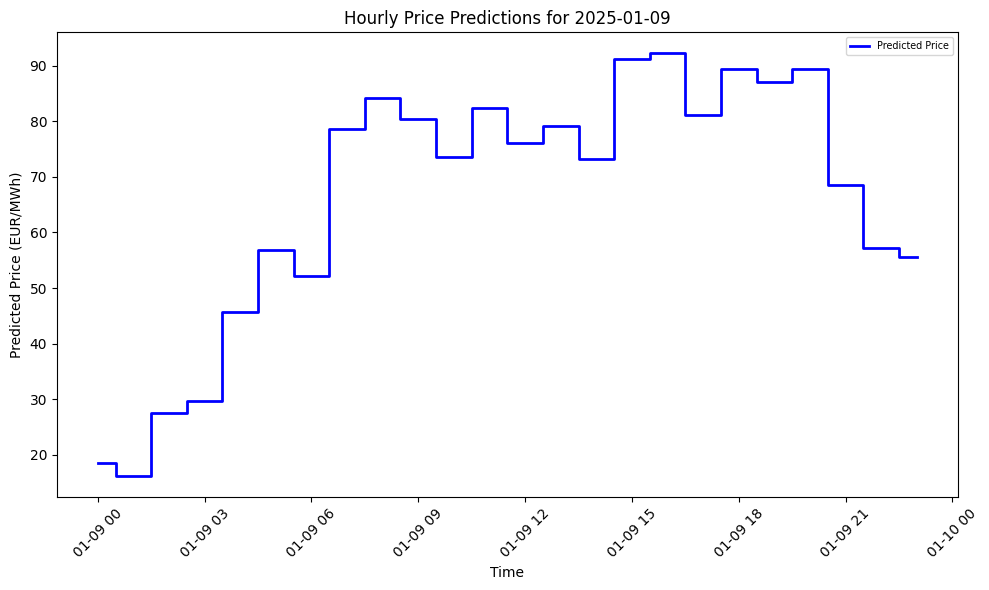

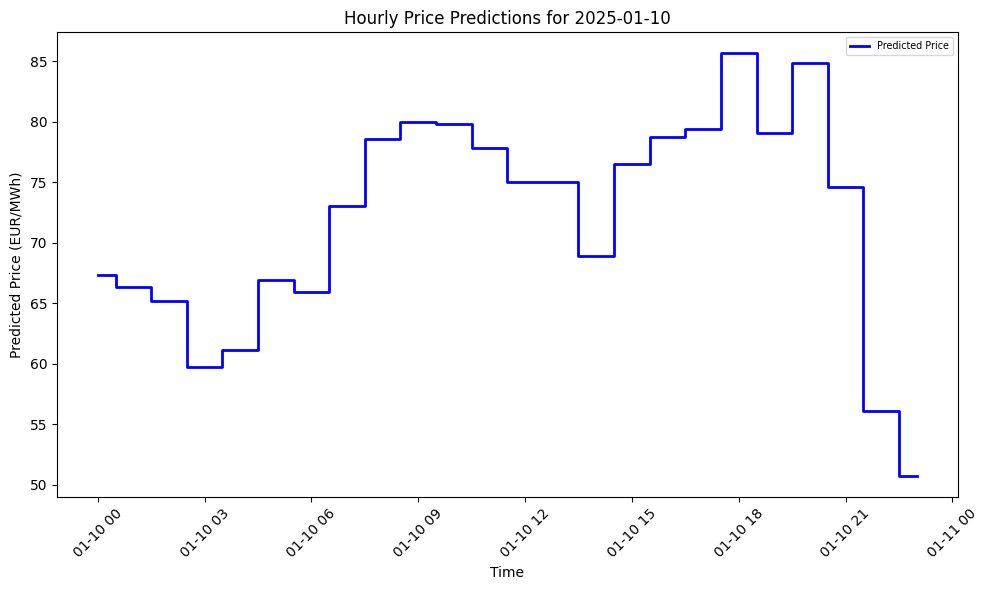

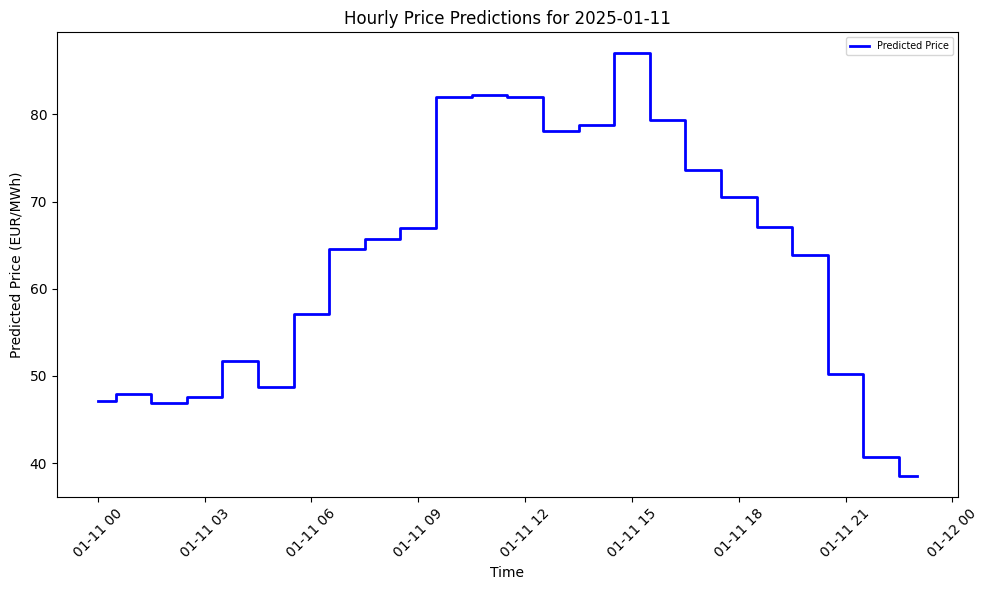

In [89]:
# For each date in the predictions DataFrame, create a separate plot and save it in the plots folder
# Do this for both SE3 and SE4 predictions
for i, date in enumerate(predictions_df_se3['time'].dt.date.unique()):
    file_path = f"../docs/plots/hourly_price_predictions_se3_{i}.png"
    plt = plot_hourly_price_predictions(predictions_df_se3, str(date), file_path)
    plt.show()

for i, date in enumerate(predictions_df_se4['time'].dt.date.unique()):
    file_path = f"../docs/plots/hourly_price_predictions_se4_{i}.png"
    plt = plot_hourly_price_predictions(predictions_df_se4, str(date), file_path)
    plt.show()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [ ]:
# weather_data['street'] = street
# weather_data['city'] = city
# weather_data['country'] = country
# # Fill in the number of days before the date on which you made the forecast (base_date)
# weather_data['days_before_forecast_day'] = range(1, len(weather_data)+1)
# # weather_data = weather_data.sort_values(by=['date'])
# weather_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,predicted_rolling_mean_pm25,street,country,days_before_forecast_day
1,2024-11-16 00:00:00+00:00,3.85,0.0,7.787991,123.690102,bondville,45.509464,43.169821,bondville-illinois-usa,usa,1
0,2024-11-17 00:00:00+00:00,8.85,0.0,14.458382,198.886185,bondville,48.319191,44.886278,bondville-illinois-usa,usa,2
5,2024-11-18 00:00:00+00:00,9.00,0.0,12.475961,46.169064,bondville,50.860588,46.877715,bondville-illinois-usa,usa,3
4,2024-11-19 00:00:00+00:00,14.65,0.1,21.603001,156.425278,bondville,49.073971,47.609800,bondville-illinois-usa,usa,4
3,2024-11-20 00:00:00+00:00,7.75,0.0,6.379216,16.389616,bondville,53.191223,49.470274,bondville-illinois-usa,usa,5
2,2024-11-21 00:00:00+00:00,10.50,3.5,22.614189,166.184952,bondville,46.394855,48.445135,bondville-illinois-usa,usa,6
7,2024-11-22 00:00:00+00:00,5.45,0.5,16.516901,163.539902,bondville,52.400414,49.763561,bondville-illinois-usa,usa,7
6,2024-11-23 00:00:00+00:00,5.10,0.1,4.693825,355.601379,bondville,51.475281,50.334134,bondville-illinois-usa,usa,8


In [22]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 6
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[ns, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float64            
 7   predicted_rolling_mean_pm25  8 non-null      float64            
 8   street                       8 non-null      object             
 9   country                      8 non-null      object             
 10  days_before_forecast_day     8 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [ ]:
# file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
# plt = util.plot_air_quality_forecast(city, street, weather_data, file_path)
# plt.show()

NameError: name 'city' is not defined

In [ ]:
# # Get or create feature group
# monitor_fg = fs.get_or_create_feature_group(
#     name='aq_predictions_new',
#     description='Air Quality prediction monitoring',
#     version=1,
#     primary_key=['city','street','date','days_before_forecast_day'],
#     event_time="date"
# )

In [ ]:
# monitor_fg.insert(weather_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_new_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1161369/jobs/named/aq_predictions_new_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1100271f0>, None)

In [26]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,predicted_rolling_mean_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,9.00,0.0,6.792466,302.005341,bondville,48.371498,46.790499,bondville-illinois-usa,usa,1
1,2024-11-16 00:00:00+00:00,3.85,0.0,7.787991,123.690102,bondville,45.509464,43.169821,bondville-illinois-usa,usa,1


In [ ]:
# air_quality_fg = fs.get_feature_group(
#     name='air_quality_new',
#     version=1,
# )
# air_quality_df = air_quality_fg.read()
# air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 


,date,pm25,rolling_mean_pm25,country,city,street,url
0,2015-09-14 00:00:00+00:00,21.0,17.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
1,2019-02-27 00:00:00+00:00,55.0,41.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
2,2021-04-06 00:00:00+00:00,59.0,60.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3,2023-10-13 00:00:00+00:00,34.0,35.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
4,2016-05-01 00:00:00+00:00,27.0,34.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
...,...,...,...,...,...,...,...
3364,2020-12-08 00:00:00+00:00,57.0,49.333333,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3365,2020-09-10 00:00:00+00:00,35.0,31.666667,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3366,2021-04-30 00:00:00+00:00,26.0,43.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638
3367,2024-11-14 00:00:00+00:00,52.0,52.000000,usa,bondville,bondville-illinois-usa,https://api.waqi.info/feed/@7638


In [ ]:
# outcome_df = air_quality_df[['date', 'pm25']]
# preds_df =  monitoring_df[['date', 'predicted_pm25']]

# hindcast_df = pd.merge(preds_df, outcome_df, on="date")
# hindcast_df = hindcast_df.sort_values(by=['date'])


# # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# if len(hindcast_df) == 0:
#     pass
#     # hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
# hindcast_df

,date,predicted_pm25,pm25
0,2024-11-15 00:00:00+00:00,48.371498,32.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

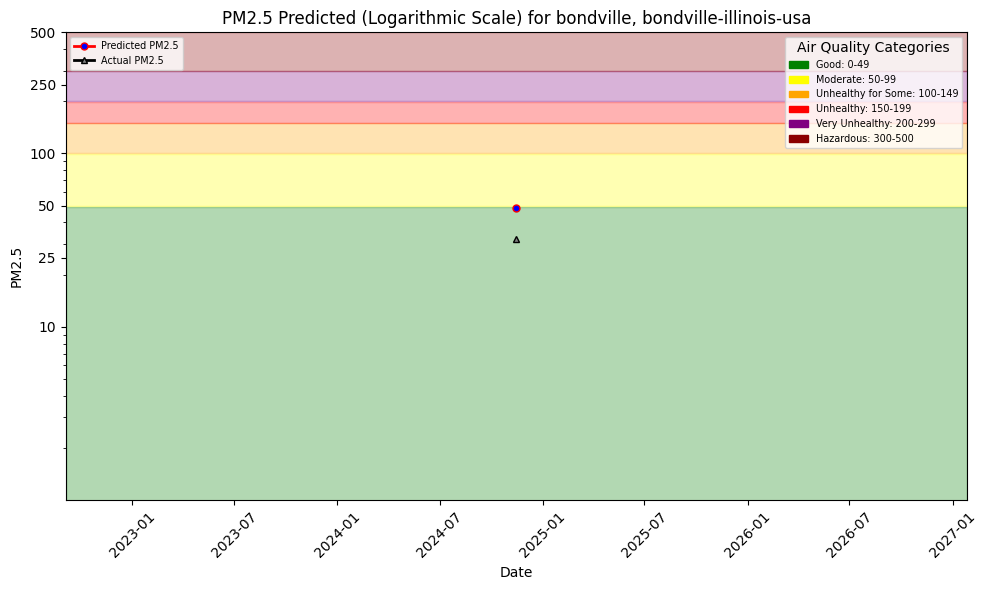

In [ ]:
# file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
# plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
# plt.show()

---